                                CS5234 Combinatorial And Graph Algorithms
                                

Progress Report.

We have found two dataset, one the text data and the other is image data. We have already perfomred random projection on the text data, and tried Kmean clustering.
                                

** Some helpful links for learning about the basics of random projection and J-L lemma **


#### J-L Lemma
* This blog post http://www.johnmyleswhite.com/notebook/2014/03/24/a-note-on-the-johnson-lindenstrauss-lemma/ is a good start for learning about J-L lemma and random projection. DO READ IT.

#### Random Projection
* This paper http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.76.8124&rep=rep1&type=pdf gives a thorough introduction of random projection and its experimental performance.

#### Working with RP in sklearn
* Random projection: http://scikit-learn.org/stable/modules/random_projection.html
* J-L lemma: http://scikit-learn.org/stable/auto_examples/plot_johnson_lindenstrauss_bound.html


In [1]:
import numpy as np
from sklearn import random_projection
from sklearn import neighbors, datasets, metrics, cross_validation
from sklearn.decomposition import PCA
from sklearn.random_projection import johnson_lindenstrauss_min_dim
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import KMeans
import timeit

/Users/ruizhi/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Using sklearn for Random Projection
The following few blocks demonstrate how we can perform random projection using sklearn. 

In [12]:
# the min dimension that guarantees the specific epsilon, determined by J-L Lemma
k_min = johnson_lindenstrauss_min_dim(n_samples=1e3, eps=0.2)
k_min

1594

In [13]:
# Examplar data before random projection
X = np.random.rand(1000, 10000) # the first dim is number of samples, second is original number of features

In [14]:
RP = random_projection.GaussianRandomProjection(n_components=k_min, eps=0.2)

In [15]:
# Result after random projection
X_new = RP.fit_transform(X)
X_new.shape

(1000, 1594)

In [16]:
SRP = random_projection.SparseRandomProjection(n_components=k_min, eps=0.2)

In [17]:
# Result after sparse random projection
X_new = SRP.fit_transform(X)
X_new.shape

(1000, 1594)

# Using RP on Text Data

In [2]:
from sklearn.datasets import fetch_20newsgroups_vectorized, fetch_20newsgroups
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
from time import time
from sklearn.random_projection import SparseRandomProjection

In [3]:
data = fetch_20newsgroups_vectorized().data[:500]

In [20]:
n_samples, n_features = data.shape
print("Embedding %d samples with dim %d using various random projections"
      % (n_samples, n_features))

n_components_range = np.array([1000, 2000]) # can try with 300, 1000, 10000
dists = euclidean_distances(data, squared=True).ravel()

# select only non-identical samples pairs
nonzero = dists != 0
dists = dists[nonzero]

Embedding 500 samples with dim 130107 using various random projections


In [21]:
k_min = johnson_lindenstrauss_min_dim(n_samples=n_features, eps=0.2)
print("Require %d dimensions after projection according to J-L lemma"
      % (k_min))

Require 2717 dimensions after projection according to J-L lemma


Projected 500 samples from 130107 to 1000 in 0.523s
Random matrix with size: 4.329MB
Mean distances rate: 1.00 (0.10)
Projected 500 samples from 130107 to 2000 in 1.009s
Random matrix with size: 8.651MB
Mean distances rate: 1.04 (0.08)


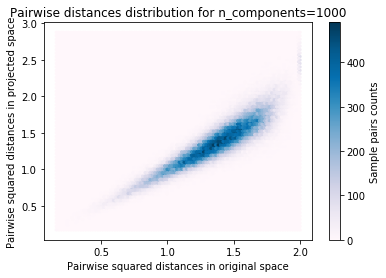

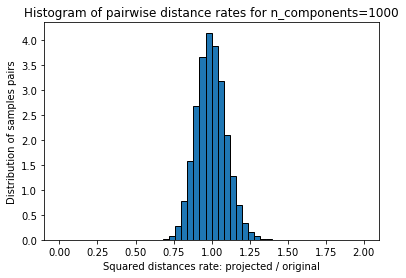

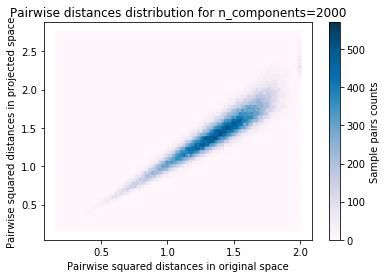

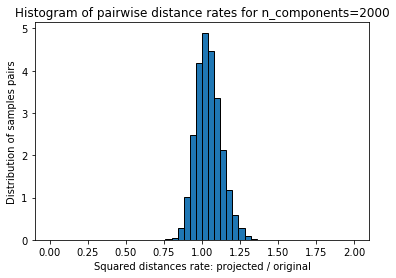

In [22]:
for n_components in n_components_range:
    t0 = time()
    rp = SparseRandomProjection(n_components=n_components)
    projected_data = rp.fit_transform(data)
    print("Projected %d samples from %d to %d in %0.3fs"
          % (n_samples, n_features, n_components, time() - t0))
    if hasattr(rp, 'components_'):
        n_bytes = rp.components_.data.nbytes
        n_bytes += rp.components_.indices.nbytes
        print("Random matrix with size: %0.3fMB" % (n_bytes / 1e6))

    projected_dists = euclidean_distances(
        projected_data, squared=True).ravel()[nonzero]

    plt.figure()
    plt.hexbin(dists, projected_dists, gridsize=100, cmap=plt.cm.PuBu)
    plt.xlabel("Pairwise squared distances in original space")
    plt.ylabel("Pairwise squared distances in projected space")
    plt.title("Pairwise distances distribution for n_components=%d" %
              n_components)
    cb = plt.colorbar()
    cb.set_label('Sample pairs counts')

    rates = projected_dists / dists
    print("Mean distances rate: %0.2f (%0.2f)"
          % (np.mean(rates), np.std(rates)))

    plt.figure()
    plt.hist(rates, bins=50, normed=True, range=(0., 2.), edgecolor='k')
    plt.xlabel("Squared distances rate: projected / original")
    plt.ylabel("Distribution of samples pairs")
    plt.title("Histogram of pairwise distance rates for n_components=%d" %
              n_components)

plt.show()

# Using RP on Image Data

In [4]:
import numpy as np
import matplotlib.pyplot as plt

from time import time

from sklearn.datasets import fetch_olivetti_faces
from sklearn.utils.validation import check_random_state

from sklearn.metrics.pairwise import euclidean_distances
from sklearn.random_projection import SparseRandomProjection

In [5]:
data = fetch_olivetti_faces()
data = data.images.reshape((len(data.images), -1))

downloading Olivetti faces from http://cs.nyu.edu/~roweis/data/olivettifaces.mat to /Users/ruizhi/scikit_learn_data


In [6]:
n_samples, n_features = data.shape
print("Embedding %d samples with dim %d using various random projections"
      % (n_samples, n_features))

n_components_range = np.array([1000, 2000]) # can try with 300, 1000, 10000
dists = euclidean_distances(data, squared=True).ravel()

# select only non-identical samples pairs
nonzero = dists != 0
dists = dists[nonzero]

Embedding 400 samples with dim 4096 using various random projections


In [26]:
k_min = johnson_lindenstrauss_min_dim(n_samples=n_features, eps=0.2)
print("Require %d dimensions after projection according to J-L lemma"
      % (k_min))

Require 1919 dimensions after projection according to J-L lemma


Projected 400 samples from 4096 to 1000 in 0.135s
Random matrix with size: 0.769MB
Mean distances rate: 0.99 (0.04)
Projected 400 samples from 4096 to 2000 in 0.261s
Random matrix with size: 1.530MB
Mean distances rate: 0.99 (0.03)


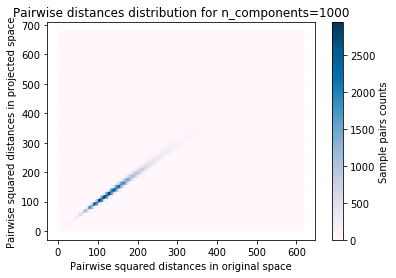

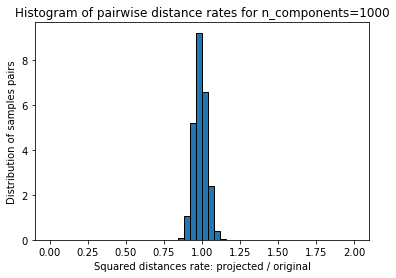

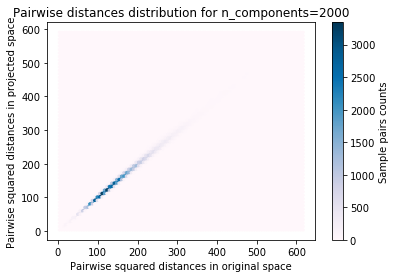

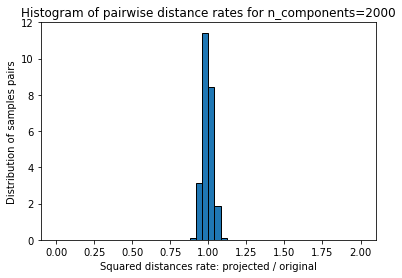

In [27]:
for n_components in n_components_range:
    t0 = time()
    rp = SparseRandomProjection(n_components=n_components)
    projected_data = rp.fit_transform(data)
    print("Projected %d samples from %d to %d in %0.3fs"
          % (n_samples, n_features, n_components, time() - t0))
    if hasattr(rp, 'components_'):
        n_bytes = rp.components_.data.nbytes
        n_bytes += rp.components_.indices.nbytes
        print("Random matrix with size: %0.3fMB" % (n_bytes / 1e6))

    projected_dists = euclidean_distances(
        projected_data, squared=True).ravel()[nonzero]

    plt.figure()
    plt.hexbin(dists, projected_dists, gridsize=100, cmap=plt.cm.PuBu)
    plt.xlabel("Pairwise squared distances in original space")
    plt.ylabel("Pairwise squared distances in projected space")
    plt.title("Pairwise distances distribution for n_components=%d" %
              n_components)
    cb = plt.colorbar()
    cb.set_label('Sample pairs counts')

    rates = projected_dists / dists
    print("Mean distances rate: %0.2f (%0.2f)"
          % (np.mean(rates), np.std(rates)))

    plt.figure()
    plt.hist(rates, bins=50, normed=True, range=(0., 2.), edgecolor='k')
    plt.xlabel("Squared distances rate: projected / original")
    plt.ylabel("Distribution of samples pairs")
    plt.title("Histogram of pairwise distance rates for n_components=%d" %
              n_components)

plt.show()

# kNN on Text Data

## Data Preprocessing

In [4]:
# TODO: perform kNN on our text dataset
# compare **performance** and **time complexity** before
# and after random projection.
newsgroups_train = fetch_20newsgroups(subset='train')

In [5]:
# All the categories in the dataset
# we do not need to use all of them
# for the sake of running time
list(newsgroups_train.target_names)

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [6]:
newsgroups_train.target

array([7, 4, 4, ..., 3, 1, 8])

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
categories = ['alt.atheism', 'talk.politics.guns',
              'comp.graphics', 'sci.med', 'misc.forsale']
newsgroups_train_and_test = fetch_20newsgroups(subset='train',
                                categories=categories)
# newsgroups_train_and_test = fetch_20newsgroups(subset='train')
print(len(newsgroups_train_and_test.filenames))
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(newsgroups_train_and_test.data) 

# Notice that the vectors returned above is in scipy sparse matrix format.
# we would like to convert it to normal numpy format
vectors = vectors.toarray()
vectors.shape

2789


(2789, 43807)

## Performance Evaluation Function

In [18]:
def test_classifier(X, y, clf, test_size=0.4, y_names=None, confusion=False):
    # train-test split
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=test_size)

    clf.fit(X_train, y_train)
    y_predicted = clf.predict(X_test)

    if not confusion:
        print('Classification report:')
        print(metrics.classification_report(y_test, y_predicted, target_names=y_names))
    else:
        print('Confusion Matrix:')
        print(metrics.confusion_matrix(y_test, y_predicted))

## Set up kNN Classifier

In [81]:
n_neighbors = 15
weights = 'uniform'
# weights = 'distance'
clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)

## kNN on Original Data

In [34]:
start_time = timeit.default_timer()
test_classifier(vectors, newsgroups_train_and_test.target, clf, y_names=newsgroups_train_and_test.target_names, confusion=False)
elapsed_original = timeit.default_timer() - start_time

Classification report:
                       precision    recall  f1-score   support

          alt.atheism       0.62      0.91      0.74       196
        comp.graphics       0.97      0.78      0.87       222
              sci.med       0.97      0.74      0.84       237
talk.politics.mideast       0.76      0.96      0.85       225
   talk.religion.misc       0.81      0.52      0.63       160

          avg / total       0.83      0.80      0.80      1040



In [35]:
print(elapsed_original)

109.71652391348636


## kNN on Data after RP

In [36]:
start_time = timeit.default_timer()
# Apply RP
n_components = 2000
RP = random_projection.GaussianRandomProjection(n_components=n_components)
# Result after random projection
vectors_RP = RP.fit_transform(vectors)
vectors_RP.shape
elapsed_transform_RP = timeit.default_timer() - start_time

In [37]:
print(elapsed_transform_RP)

5.68743002810595


In [38]:
start_time = timeit.default_timer()
test_classifier(vectors_RP, newsgroups_train_and_test.target, clf, y_names=newsgroups_train_and_test.target_names, confusion=False)
elapsed_RP = timeit.default_timer() - start_time

Classification report:
                       precision    recall  f1-score   support

          alt.atheism       0.51      0.89      0.65       188
        comp.graphics       0.95      0.70      0.80       214
              sci.med       0.96      0.63      0.76       238
talk.politics.mideast       0.76      0.95      0.85       240
   talk.religion.misc       0.84      0.49      0.62       160

          avg / total       0.81      0.75      0.75      1040



In [39]:
print(elapsed_RP)

5.51448083934423


## kNN on Data after SRP

In [40]:
start_time = timeit.default_timer()
# Apply SRP
n_components = 2000
SRP = random_projection.SparseRandomProjection(n_components=n_components)
# Result after random projection
vectors_SRP = SRP.fit_transform(vectors)
vectors_SRP.shape
elapsed_transform_SRP = timeit.default_timer() - start_time

In [41]:
print(elapsed_transform_SRP)

2.7783678002188594


In [42]:
start_time = timeit.default_timer()
test_classifier(vectors_SRP, newsgroups_train_and_test.target, clf, y_names=newsgroups_train_and_test.target_names, confusion=False)
elapsed_SRP = timeit.default_timer() - start_time

Classification report:
                       precision    recall  f1-score   support

          alt.atheism       0.90      0.74      0.81       205
        comp.graphics       0.93      0.70      0.80       222
              sci.med       0.89      0.52      0.65       242
talk.politics.mideast       0.49      0.98      0.66       242
   talk.religion.misc       0.75      0.49      0.59       129

          avg / total       0.79      0.70      0.71      1040



In [43]:
print(elapsed_SRP)

5.384764140256877


## kNN on Data after PCA

In [44]:
start_time = timeit.default_timer()
# Apply SRP
n_components = 2000
pca = PCA(n_components=n_components)
# Result after random projection
vectors_PCA = pca.fit(vectors).transform(vectors)
vectors_PCA.shape
elapsed_transform_PCA = timeit.default_timer() - start_time

In [45]:
print(elapsed_transform_PCA)

73.0100002343664


In [46]:
start_time = timeit.default_timer()
test_classifier(vectors_PCA, newsgroups_train_and_test.target, clf, y_names=newsgroups_train_and_test.target_names, confusion=False)
elapsed_PCA = timeit.default_timer() - start_time

Classification report:
                       precision    recall  f1-score   support

          alt.atheism       0.51      0.94      0.66       193
        comp.graphics       0.98      0.57      0.72       226
              sci.med       0.97      0.57      0.72       244
talk.politics.mideast       0.67      0.97      0.80       237
   talk.religion.misc       0.95      0.45      0.61       140

          avg / total       0.82      0.71      0.71      1040



In [47]:
print(elapsed_PCA)

5.313202460727098


# Clustering on Text Data

In [83]:
from sklearn.feature_extraction.text import TfidfVectorizer
categories = [
    'alt.atheism',
    'talk.religion.misc',
    'comp.graphics',
    'sci.space'
]
newsgroups_dataset = fetch_20newsgroups(subset='all', categories=categories,
                                        shuffle=True, random_state=42)
vectorizer = TfidfVectorizer(max_df=0.5, max_features=10000,
                             min_df=2, stop_words='english',
                             use_idf=True)

vectors = vectorizer.fit_transform(newsgroups_dataset.data) 

# Notice that the vectors returned above is in scipy sparse matrix format.
# we would like to convert it to normal numpy format
vectors = vectors.toarray()
vectors.shape

(3387, 10000)

In [84]:
labels = newsgroups_dataset.target
true_k = np.unique(labels).shape[0]
true_k

4

## K-Means on Original Data

In [92]:
km = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=100)

start_time = timeit.default_timer()
km.fit(vectors)
elapsed_original = timeit.default_timer() - start_time

In [93]:
print(elapsed_original)

41.696310197992716


In [94]:
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))

Homogeneity: 0.217
Completeness: 0.392
V-measure: 0.279


## K-Means on Data after RP

In [79]:
# Apply RP
n_components = 2000
RP = random_projection.GaussianRandomProjection(n_components=n_components)
# Result after random projection
vectors_RP = RP.fit_transform(vectors)

In [80]:
km = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=100)

start_time = timeit.default_timer()
km.fit(vectors_RP)
elapsed_RP = timeit.default_timer() - start_time

In [81]:
print(elapsed_RP)

9.391620484995656


In [82]:
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))

Homogeneity: 0.426
Completeness: 0.511
V-measure: 0.465


## K-Means on Data after SRP

In [95]:
# Apply SRP
n_components = 2000
SRP = random_projection.SparseRandomProjection(n_components=n_components)
# Result after random projection
vectors_SRP = SRP.fit_transform(vectors)

In [96]:
km = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=100)

start_time = timeit.default_timer()
km.fit(vectors_SRP)
elapsed_SRP = timeit.default_timer() - start_time

In [97]:
print(elapsed_SRP)

9.132469701988157


In [98]:
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))

Homogeneity: 0.425
Completeness: 0.511
V-measure: 0.464


## Clustering on Data afte PCA

In [99]:
# Apply PCA
n_components = 2000
pca = PCA(n_components=n_components)
# Result after random projection
vectors_PCA = pca.fit(vectors).transform(vectors)

In [100]:
km = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=100)

start_time = timeit.default_timer()
km.fit(vectors_PCA)
elapsed_PCA = timeit.default_timer() - start_time

In [101]:
print(elapsed_PCA)

7.336873683001613


In [102]:
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))

Homogeneity: 0.514
Completeness: 0.601
V-measure: 0.554


#  kNN on Image Data

In [66]:
## Data Preprocessing

In [15]:
# TODO: perform clustering and kNN on our image dataset
# compare **performance** and **time complexity** before
# and after random projection.
data = fetch_olivetti_faces()
targets = data.target

data = data.images.reshape((len(data.images), -1))
data = data[targets < 10]
targets = targets[targets < 10]

## Set up kNN Classifier

In [79]:
n_neighbors = 5
weights = 'uniform'
clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)

In [91]:
def test_classifier_n_time(X, y, clf, test_size=0.4, y_names=None, n_time=100):
    precision_sum = 0
    recall_sum = 0
    f1_sum = 0
    for i in range(n_time):
        X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=test_size)

        clf.fit(X_train, y_train)
        y_predicted = clf.predict(X_test)

        precision_sum += metrics.precision_score(y_test, y_predicted, average='weighted')
        recall_sum += metrics.recall_score(y_test, y_predicted, average='weighted')
        f1_sum += metrics.f1_score(y_test, y_predicted, average='weighted')
    print(precision_sum/n_time, recall_sum/n_time, f1_sum/n_time)

## kNN on Original Data

In [112]:
names = [str(i) for i in np.unique(targets)]

In [113]:
start_time = timeit.default_timer()
test_classifier_n_time(data, targets, clf, y_names=names, n_time=100)
elapsed_original = timeit.default_timer() - start_time

/Users/ruizhi/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ruizhi/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ruizhi/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/ruizhi/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


0.795008823121 0.70325 0.69800617483


In [114]:
print(elapsed_original)

1.5910276329959743


## kNN on Data after RP

In [115]:
start_time = timeit.default_timer()
# Apply RP
n_components = 500
RP = random_projection.GaussianRandomProjection(n_components=n_components)
# Result after random projection
vectors_RP = RP.fit_transform(data)
elapsed_transform_RP = timeit.default_timer() - start_time

In [116]:
print(elapsed_transform_RP)

0.07784809000440873


In [117]:
start_time = timeit.default_timer()
test_classifier_n_time(vectors_RP, targets, clf, y_names=names, n_time=100)
elapsed_RP = timeit.default_timer() - start_time

/Users/ruizhi/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ruizhi/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ruizhi/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/ruizhi/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


0.787266789461 0.69325 0.684887746733


In [118]:
print(elapsed_RP)

0.3811886870244052


## kNN on Data after SRP

In [137]:
start_time = timeit.default_timer()
# Apply SRP
n_components = 500
SRP = random_projection.SparseRandomProjection(n_components=n_components)
# Result after random projection
vectors_SRP = SRP.fit_transform(data)
vectors_SRP.shape
elapsed_transform_SRP = timeit.default_timer() - start_time

In [138]:
print(elapsed_transform_SRP)

0.05168343900004402


In [139]:
start_time = timeit.default_timer()
test_classifier_n_time(vectors_SRP, targets, clf, y_names=names, n_time=100)
elapsed_SRP = timeit.default_timer() - start_time

/Users/ruizhi/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/ruizhi/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/ruizhi/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ruizhi/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.797896849229 0.70175 0.697869928397


In [140]:
print(elapsed_SRP)

0.3587158969894517


## kNN on Data after PCA

In [141]:
start_time = timeit.default_timer()
# Apply SRP
n_components = 500
pca = PCA(n_components=n_components)
# Result after random projection
vectors_PCA = pca.fit(data).transform(data)
vectors_PCA.shape
elapsed_transform_PCA = timeit.default_timer() - start_time

In [142]:
print(elapsed_transform_PCA)

0.02341742001590319


In [143]:
start_time = timeit.default_timer()
test_classifier_n_time(vectors_PCA, targets, clf, y_names=names, n_time=100)
elapsed_PCA = timeit.default_timer() - start_time

/Users/ruizhi/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ruizhi/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ruizhi/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/ruizhi/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


0.800054184704 0.7065 0.703010244616


In [144]:
print(elapsed_PCA)

0.21940164497937076


# Clustering on Image Data

In [151]:
dataset = fetch_olivetti_faces()
labels = dataset.target
faces = dataset.data

faces = faces[labels < 10]
labels = labels[labels < 10]

In [152]:
true_k = np.unique(labels).shape[0]
true_k

10

# K-Means on Original Data

In [154]:
km = KMeans(n_clusters=true_k, init='k-means++', max_iter=500, n_init=40)

start_time = timeit.default_timer()
km.fit(faces)
elapsed_original = timeit.default_timer() - start_time

In [155]:
print(elapsed_RP)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))

0.3811886870244052
Homogeneity: 0.646
Completeness: 0.675
V-measure: 0.660


# K-Means on Data after RP

In [156]:
# Apply RP
n_components = 500
RP = random_projection.GaussianRandomProjection(n_components=n_components)
# Result after random projection
vectors_RP = RP.fit_transform(faces)

In [157]:
km = KMeans(n_clusters=true_k, init='k-means++', max_iter=500, n_init=40)

start_time = timeit.default_timer()
km.fit(vectors_RP)
elapsed_RP = timeit.default_timer() - start_time

In [158]:
print(elapsed_RP)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))

0.18144337998819537
Homogeneity: 0.639
Completeness: 0.667
V-measure: 0.653


# K-Means on Data after SRP

In [159]:
# Apply SRP
n_components = 500
SRP = random_projection.SparseRandomProjection(n_components=n_components)
# Result after random projection
vectors_SRP = SRP.fit_transform(faces)

In [160]:
km = KMeans(n_clusters=true_k, init='k-means++', max_iter=500, n_init=40)

start_time = timeit.default_timer()
km.fit(vectors_SRP)
elapsed_SRP = timeit.default_timer() - start_time

In [161]:
print(elapsed_SRP)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))

0.1742935010115616
Homogeneity: 0.599
Completeness: 0.620
V-measure: 0.609



# Clustering on Data afte PCA

In [162]:
# Apply PCA
n_components = 500
pca = PCA(n_components=n_components)
# Result after random projection
vectors_PCA = pca.fit(faces).transform(faces)

In [163]:
km = KMeans(n_clusters=true_k, init='k-means++', max_iter=500, n_init=40)

start_time = timeit.default_timer()
km.fit(vectors_PCA)
elapsed_PCA = timeit.default_timer() - start_time

In [164]:
print(elapsed_PCA)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))

0.11414412100566551
Homogeneity: 0.580
Completeness: 0.603
V-measure: 0.591
